Populating the interactive namespace from numpy and matplotlib


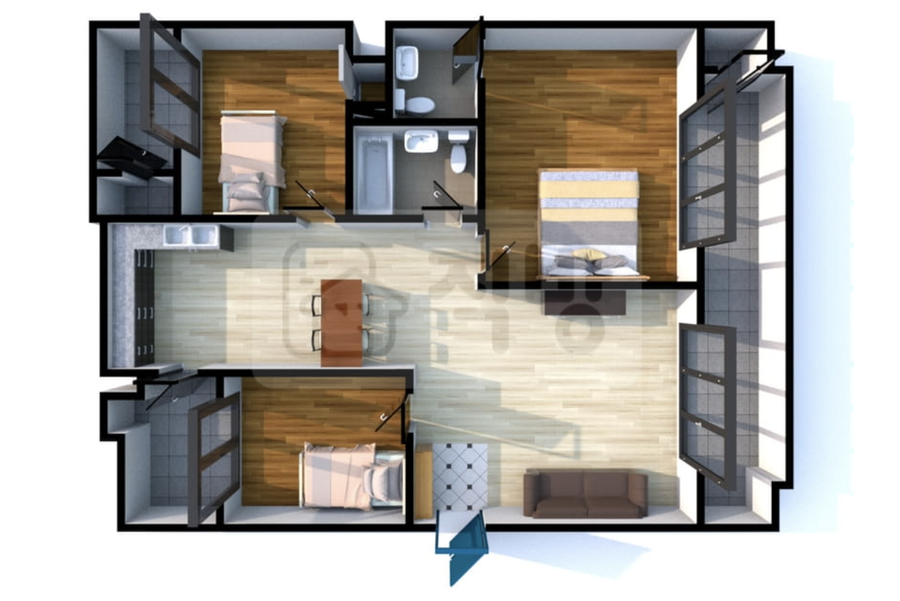

In [1]:

%pylab inline

import numpy as np

from PIL import Image

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Image.open("img/zigbang.png")